In [9]:
# Cell 1: 配置（修改这里切换模型）
CONFIG_PATH = "../configs/scheme_a.yaml"
CHECKPOINT_PATH = "../checkpoints/scheme_a/best_model.pt"
N_SAMPLES = 6


In [10]:
# Cell 2: 导入和初始化
%matplotlib inline
import os
import numpy as np
import torch
import yaml
import matplotlib.pyplot as plt

from dataset import create_datasets
from video_ecg_model import build_model

# 不依赖 cwd：在多个可能的工作目录下查找 config 文件，确定项目根目录
_cwd = os.getcwd()
_config_name = os.path.basename(CONFIG_PATH)  # e.g. scheme_a.yaml
_candidates = [
    os.path.join(_cwd, CONFIG_PATH),
    os.path.join(_cwd, "models", CONFIG_PATH),
    os.path.join(_cwd, "ECG", "configs", _config_name),
    os.path.join(_cwd, "configs", _config_name),
]
CONFIG_PATH_ABS = None
for p in _candidates:
    p = os.path.abspath(p)
    if os.path.isfile(p):
        CONFIG_PATH_ABS = p
        break
if CONFIG_PATH_ABS is None:
    raise FileNotFoundError(f"Config not found. cwd={_cwd!r}, CONFIG_PATH={CONFIG_PATH!r}. Tried: {_candidates}")
# 项目根 = config 所在目录的上一级（configs/ 的父目录）
_ROOT = os.path.dirname(os.path.dirname(CONFIG_PATH_ABS))
os.chdir(_ROOT)
# checkpoint 相对项目根（去掉开头的 ../ 或 ./，避免 join(ROOT, "../checkpoints/...") 跑到 ROOT 上一级）
_checkpoint_rel = CHECKPOINT_PATH.lstrip("./").lstrip("/")
CHECKPOINT_PATH_ABS = os.path.normpath(os.path.join(_ROOT, _checkpoint_rel))
print(f"Project root: {_ROOT}")

# 加载配置
with open(CONFIG_PATH_ABS) as f:
    cfg = yaml.safe_load(f)

# 设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# 加载模型
model = build_model(cfg).to(device)
ckpt = torch.load(CHECKPOINT_PATH_ABS, map_location=device)
# 兼容两种格式：纯 state_dict 或 {'model_state_dict': state_dict}
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
model.load_state_dict(state_dict)
model.eval()
print(f"Loaded: {CHECKPOINT_PATH_ABS}")

# 数据
use_imu = cfg.get("data", {}).get("use_imu", False)
_, _, test_ds = create_datasets(cfg)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=cfg["train"]["batch_size"],
    shuffle=False,
    num_workers=cfg.get("data", {}).get("num_workers", 0),
)
print(f"Use IMU: {use_imu}")
# 图保存目录（IDE 不显示图时可从这里打开 PNG）
os.makedirs("eval_results/visualize", exist_ok=True)


Project root: /home/xinchen/ECG
Device: cuda
Loaded: /home/xinchen/ECG/checkpoints/scheme_a/best_model.pt
Loaded 98 sample pairs
Split: train=83 pairs, val=6, test=9
Total windows: 1042
Windows: train=882, val=66, test=94
Use IMU: False


In [11]:
# Cell 3: 获取预测结果
@torch.no_grad()
def get_predictions(model, dataloader, device, use_imu, max_samples=10):
    preds, targets = [], []
    for batch in dataloader:
        if use_imu:
            video, imu, ecg = batch
            pred = model(video.to(device), imu.to(device)).cpu().numpy()
        else:
            video, ecg = batch
            pred = model(video.to(device)).cpu().numpy()
        preds.append(pred)
        targets.append(ecg.numpy())
        if sum(len(p) for p in preds) >= max_samples:
            break
    return np.concatenate(preds)[:max_samples], np.concatenate(targets)[:max_samples]

preds, targets = get_predictions(model, test_loader, device, use_imu, N_SAMPLES)
print(f"Shape: preds={preds.shape}, targets={targets.shape}")


Shape: preds=(6, 2500), targets=(6, 2500)


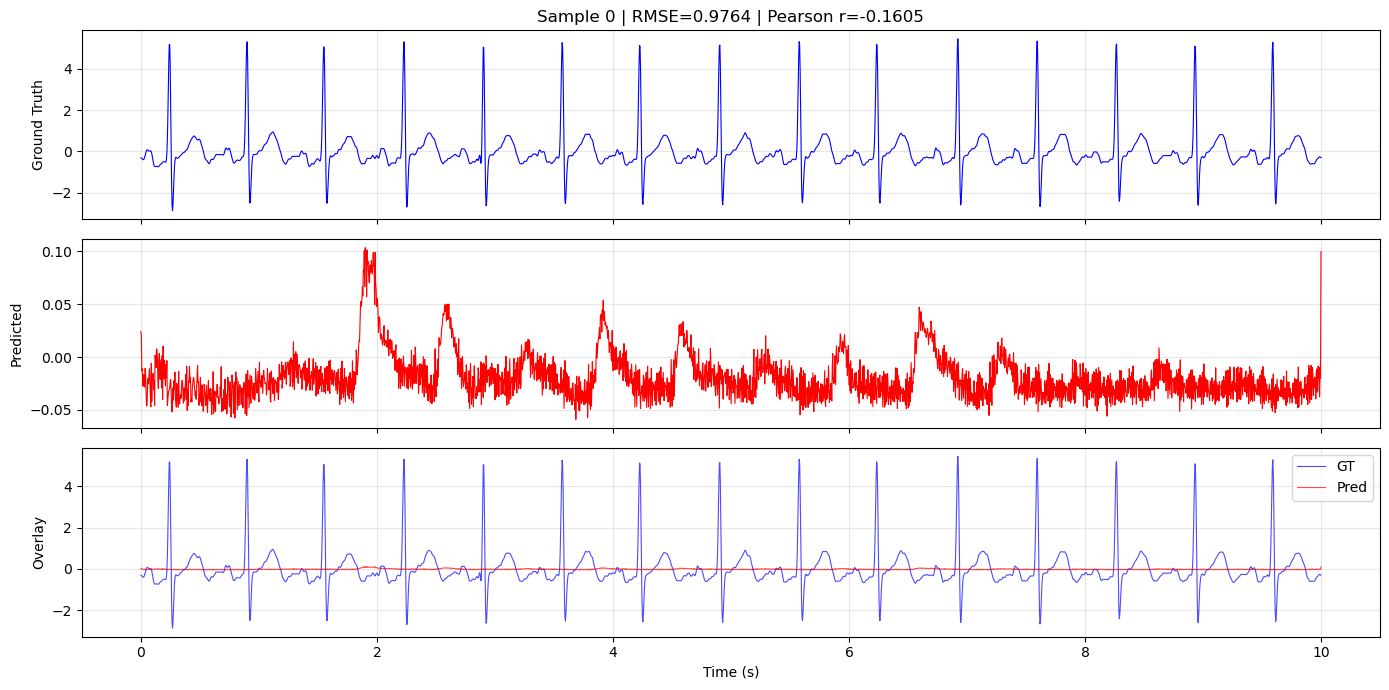

In [12]:
# Cell 4: 单样本对比（修改 idx 查看不同样本）
idx = 0  # <-- 改这里切换样本
fs = 250
t = np.arange(preds.shape[1]) / fs

pred, target = preds[idx], targets[idx]
r = np.corrcoef(pred, target)[0, 1]
rmse = np.sqrt(np.mean((pred - target) ** 2))

fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
axes[0].plot(t, target, 'b', lw=0.8)
axes[0].set_ylabel('Ground Truth')
axes[0].set_title(f'Sample {idx} | RMSE={rmse:.4f} | Pearson r={r:.4f}')

axes[1].plot(t, pred, 'r', lw=0.8)
axes[1].set_ylabel('Predicted')

axes[2].plot(t, target, 'b', lw=0.8, alpha=0.7, label='GT')
axes[2].plot(t, pred, 'r', lw=0.8, alpha=0.7, label='Pred')
axes[2].set_ylabel('Overlay')
axes[2].set_xlabel('Time (s)')
axes[2].legend()

for ax in axes:
    ax.grid(True, alpha=0.3)
plt.tight_layout()
_save = "eval_results/visualize/sample_single.png"
plt.savefig(_save, dpi=120, bbox_inches="tight")
print("Saved:", os.path.abspath(_save))
plt.show()


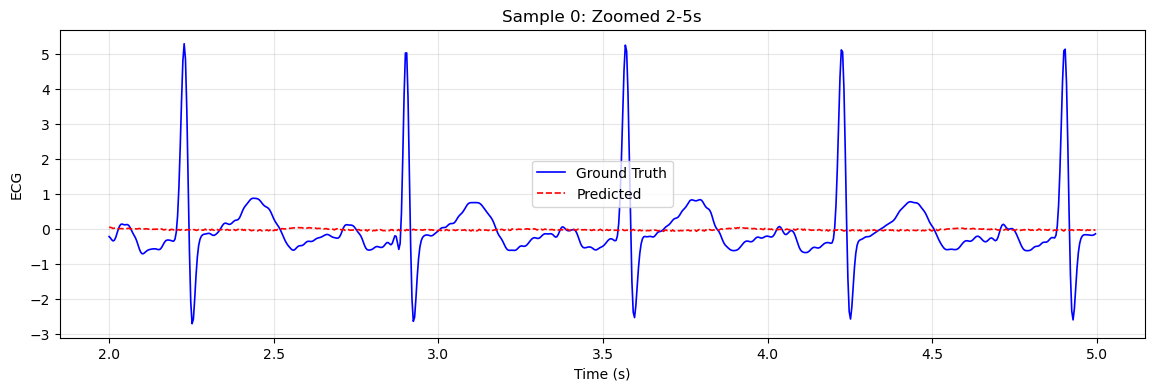

In [13]:
# Cell 5: 放大查看细节（修改 start_sec 查看不同时间段）
start_sec = 2  # <-- 改这里
duration = 3

start, end = int(start_sec * fs), int((start_sec + duration) * fs)
t_zoom = t[start:end]

plt.figure(figsize=(14, 4))
plt.plot(t_zoom, target[start:end], 'b', lw=1.2, label='Ground Truth')
plt.plot(t_zoom, pred[start:end], 'r--', lw=1.2, label='Predicted')
plt.xlabel('Time (s)')
plt.ylabel('ECG')
plt.title(f'Sample {idx}: Zoomed {start_sec}-{start_sec+duration}s')
plt.legend()
plt.grid(True, alpha=0.3)
_save = "eval_results/visualize/sample_zoom.png"
plt.savefig(_save, dpi=120, bbox_inches="tight")
print("Saved:", os.path.abspath(_save))
plt.show()


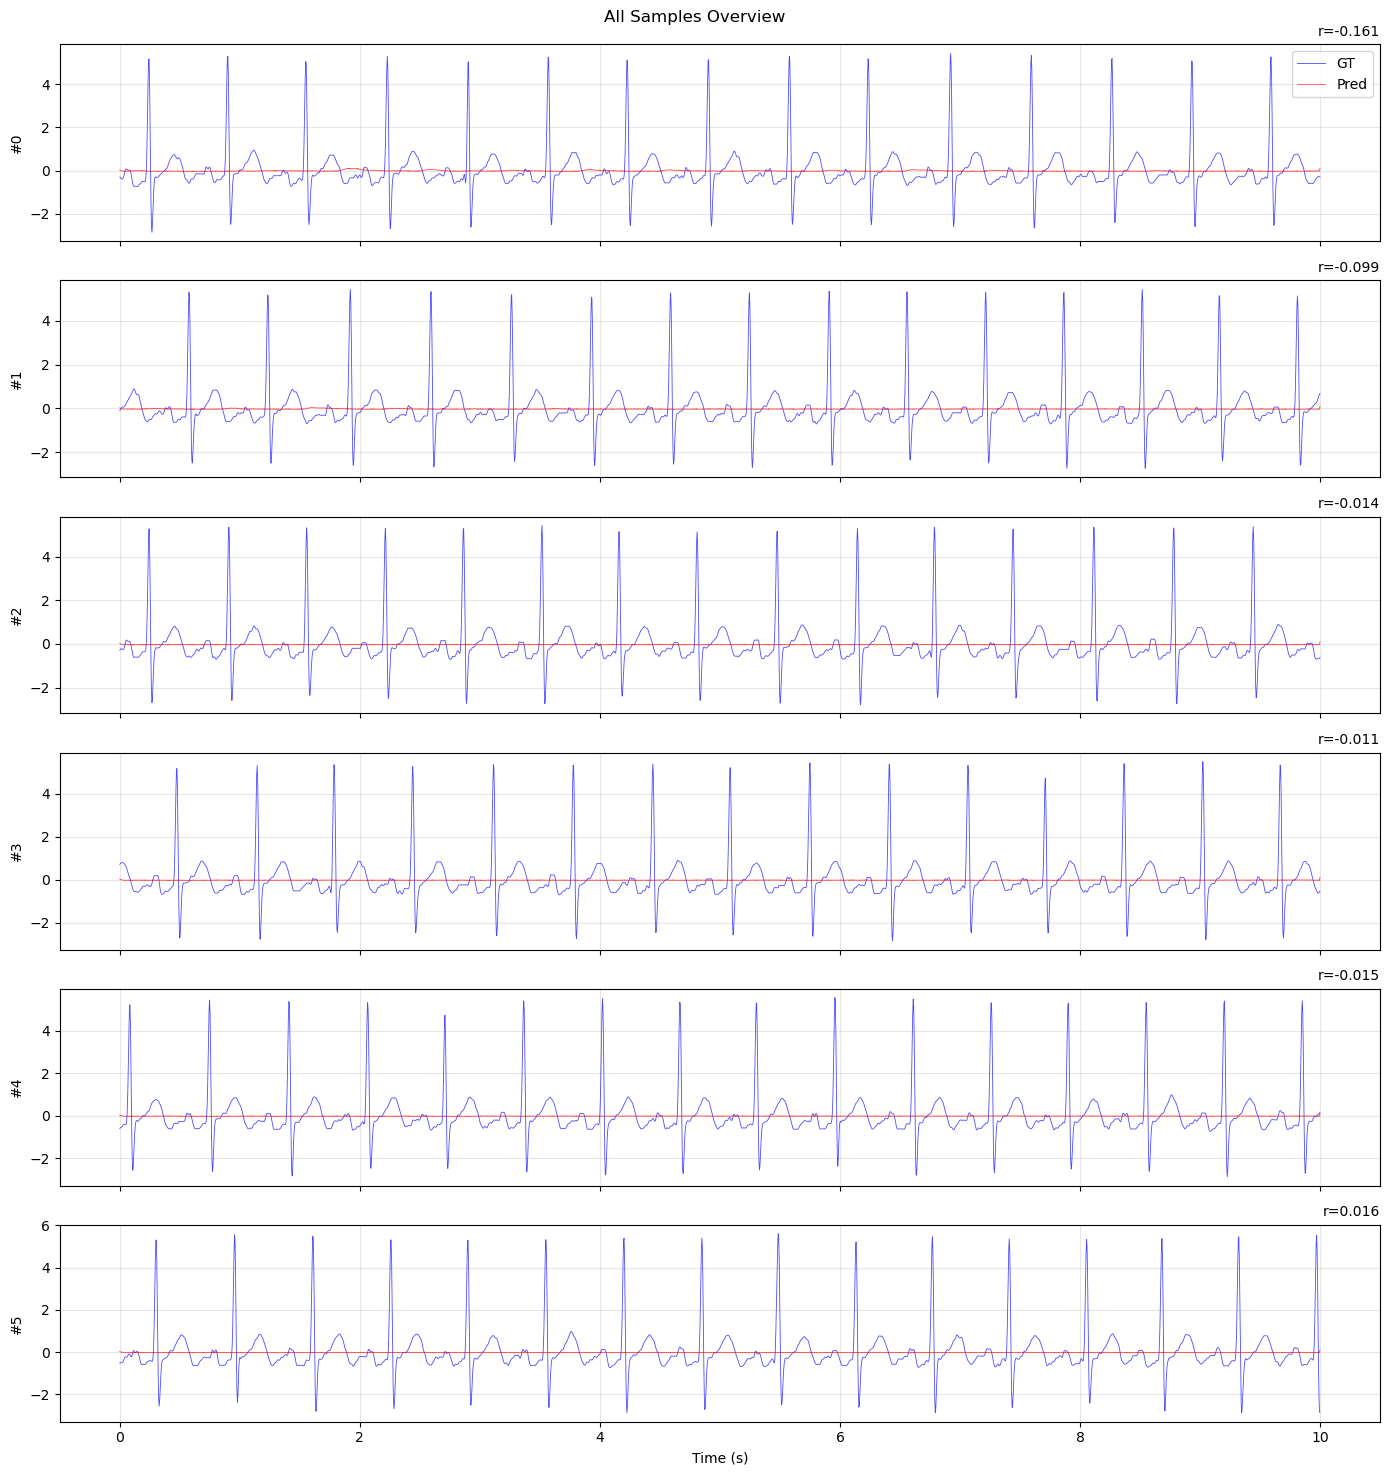

In [14]:
# Cell 6: 所有样本概览
fig, axes = plt.subplots(N_SAMPLES, 1, figsize=(14, 2.5 * N_SAMPLES), sharex=True)
for i in range(N_SAMPLES):
    r = np.corrcoef(preds[i], targets[i])[0, 1]
    axes[i].plot(t, targets[i], 'b', lw=0.6, alpha=0.7, label='GT')
    axes[i].plot(t, preds[i], 'r', lw=0.6, alpha=0.7, label='Pred')
    axes[i].set_ylabel(f'#{i}')
    axes[i].set_title(f'r={r:.3f}', loc='right', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
plt.suptitle('All Samples Overview')
plt.tight_layout()
_save = "eval_results/visualize/all_samples.png"
plt.savefig(_save, dpi=120, bbox_inches="tight")
print("Saved:", os.path.abspath(_save))
plt.show()


In [15]:
# Cell 7: 汇总指标
print("Per-sample metrics:")
print("-" * 40)
for i in range(N_SAMPLES):
    r = np.corrcoef(preds[i], targets[i])[0, 1]
    rmse = np.sqrt(np.mean((preds[i] - targets[i]) ** 2))
    mae = np.mean(np.abs(preds[i] - targets[i]))
    print(f"Sample {i}: RMSE={rmse:.4f}, MAE={mae:.4f}, r={r:.4f}")

print("-" * 40)
print(f"Mean RMSE: {np.mean([np.sqrt(np.mean((preds[i]-targets[i])**2)) for i in range(N_SAMPLES)]):.4f}")
print(f"Mean r:    {np.mean([np.corrcoef(preds[i], targets[i])[0,1] for i in range(N_SAMPLES)]):.4f}")


Per-sample metrics:
----------------------------------------
Sample 0: RMSE=0.9764, MAE=0.5577, r=-0.1605
Sample 1: RMSE=0.9821, MAE=0.5579, r=-0.0992
Sample 2: RMSE=0.9865, MAE=0.5615, r=-0.0136
Sample 3: RMSE=0.9916, MAE=0.5700, r=-0.0113
Sample 4: RMSE=1.0213, MAE=0.5772, r=-0.0154
Sample 5: RMSE=1.0346, MAE=0.5821, r=0.0159
----------------------------------------
Mean RMSE: 0.9988
Mean r:    -0.0474
